In [1]:
!pip install -Uqq datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00


In [2]:
from google.colab import userdata, runtime
import subprocess

import os
import random
import numpy as np
import torch
from torchvision.transforms import ToTensor, Compose, CenterCrop, Normalize

from datasets import load_dataset, Dataset
from PIL import Image, ImageDraw, ImageFont
import pandas as pd

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 0

n_workers = 2

Using device: cuda


In [3]:
hf_token = userdata.get('hf_token')
input_str = f'{hf_token}\nn\n'
result = subprocess.run(['huggingface-cli', 'login'], input=input_str, text=True, capture_output=True)
print(result.stdout)


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Add token as git credential? (Y/n) Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful



In [4]:
results_dir = '/content/drive/MyDrive/Colab_Notebooks/dye_test_opt/ternary/results'

context_sz = 154 # 1x1 meter context
seed = 0

In [5]:
ds = load_dataset('mpg-ranch/dye_test', split='test')

# Preprocessing transforms
preprocs = Compose([
    CenterCrop((context_sz, context_sz)),
])

def preproc_transforms(examples):
    examples["img"] = [preprocs(image.convert("RGB")) for image in examples["image"]]
    return examples

print("Applying preprocessing transforms...")
test_ds = ds.map(preproc_transforms, remove_columns=["image"], batched=True, batch_size=len(ds))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Applying preprocessing transforms...


Map:   0%|          | 0/549 [00:00<?, ? examples/s]

In [23]:
def stitch_images(images, space=5):
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths) + (len(images) - 1) * space  # Add space for the white gaps between images
    max_height = max(heights)

    new_img = Image.new('RGB', (total_width, max_height), 'white')  # 'white' background for the spaces

    x_offset = 0
    for im in images:
        new_img.paste(im, (x_offset, 0))
        x_offset += im.size[0] + space  # Move to the right for the next image plus the white space

    return new_img

In [25]:
def get_font(size, weight='regular'):
    try:
        if weight == 'regular':
            font_file = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"
        elif weight == 'bold':
            font_file = "/usr/share/fonts/truetype/liberation/LiberationSans-Bold.ttf"
        else:
            raise ValueError(f"Unsupported font weight: {weight}")
        return ImageFont.truetype(font_file, size)
    except IOError:
        # If the font file is not available, use the default font
        return ImageFont.load_default()

red_and_blue = test_ds.filter(lambda x: x['color'] in ['red', 'blue'])

# Group by 'idx' and process the groups
grouped_by_idx = {}
for item in red_and_blue:
    idx = item['idx']
    if idx not in grouped_by_idx:
        grouped_by_idx[idx] = []
    grouped_by_idx[idx].append(item)

# Define the month order for sorting
month_order = ['may', 'july', 'october']
month_names = ['May', 'July', 'October']  # Capitalized month names

new_data = []
for idx, items in grouped_by_idx.items():
    # Sort the items by month according to the specified order
    items_sorted = sorted(items, key=lambda x: month_order.index(x['month']) if x['month'] in month_order else -1)

    if len(items_sorted) == 3:  # Ensure we have one image for each of the three months
        images = [item['img'] for item in items_sorted]
        stitched_image = stitch_images(images)

        metadata = items_sorted[0]  # Assuming all items have the same metadata except for 'month' and 'img'
        text_to_add = f"{metadata['color']}-{metadata['concentration']}-{metadata['size']}"

        # Draw text on the lower left-hand corner of the image
        draw = ImageDraw.Draw(stitched_image)
        font = get_font(20, weight='bold')  # Use a 16-point font

        text_size = draw.textsize(text_to_add, font)
        text_position = (10, stitched_image.height - text_size[1] - 10)  # 10 pixels from bottom left corner
        draw.text(text_position, text_to_add, font=font, fill='white')

        # Add month labels at the top
        for i, month in enumerate(month_names):
            month_position = (i * stitched_image.width // 3 + 10, 10)  # Adjust the position as needed
            draw.text(month_position, month, font=font, fill='white')

        metadata['img'] = stitched_image
        metadata.pop('month', None)  # Remove 'month' as it's no longer relevant
        new_data.append(metadata)

new_dataset = Dataset.from_dict({k: [d[k] for d in new_data] for k in new_data[0]})

<ipython-input-25-f91b845623ce>:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text_to_add, font)
<ipython-input-25-f91b845623ce>:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text_to_add, font)
<ipython-input-25-f91b845623ce>:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text_to_add, font)
<ipython-input-25-f91b845623ce>:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_size = draw.textsize(text_to_add, font)
<ipython-input-25-f91b845623ce>:44: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

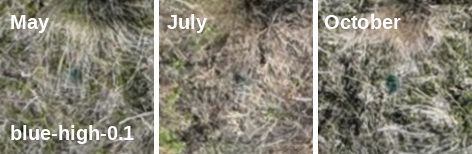

In [26]:
filtered = new_dataset.filter(lambda x: x['color'] == 'blue' and x['concentration'] == 'high' and x['size'] == '0.1')
filtered
blue_high_0o1 = filtered[2]['img']
blue_high_0o1

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

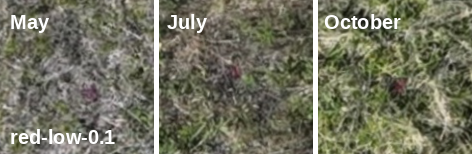

In [27]:
filtered = new_dataset.filter(lambda x: x['color'] == 'red' and x['concentration'] == 'low' and x['size'] == '0.1')
filtered
red_low_0o1 = filtered[0]['img']
red_low_0o1

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

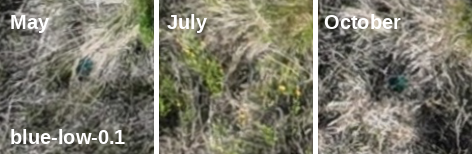

In [28]:
filtered = new_dataset.filter(lambda x: x['color'] == 'blue' and x['concentration'] == 'low' and x['size'] == '0.1')
filtered
blue_low_0o1 = filtered[6]['img']
blue_low_0o1

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

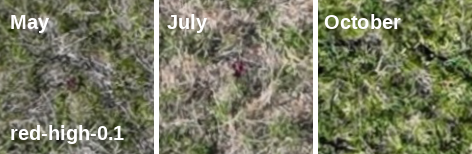

In [29]:
filtered = new_dataset.filter(lambda x: x['color'] == 'red' and x['concentration'] == 'high' and x['size'] == '0.1')
filtered
red_high_0o1 = filtered[0]['img']
red_high_0o1

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

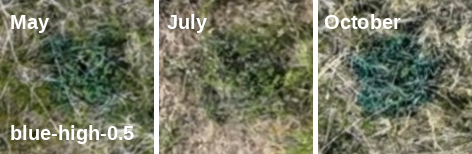

In [30]:
filtered = new_dataset.filter(lambda x: x['color'] == 'blue' and x['concentration'] == 'high' and x['size'] == '0.5')
filtered
blue_high_0o5 = filtered[5]['img']
blue_high_0o5

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

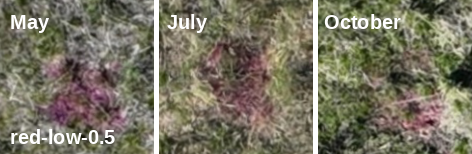

In [31]:
filtered = new_dataset.filter(lambda x: x['color'] == 'red' and x['concentration'] == 'low' and x['size'] == '0.5')
filtered
red_low_0o5 = filtered[0]['img']
red_low_0o5

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

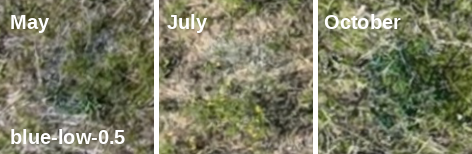

In [32]:
filtered = new_dataset.filter(lambda x: x['color'] == 'blue' and x['concentration'] == 'low' and x['size'] == '0.5')
filtered
blue_low_0o5 = filtered[5]['img']
blue_low_0o5

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

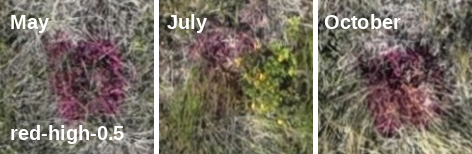

In [33]:
filtered = new_dataset.filter(lambda x: x['color'] == 'red' and x['concentration'] == 'high' and x['size'] == '0.5')
filtered
red_high_0o5 = filtered[0]['img']
red_high_0o5

In [34]:
def join_v(im_list, space=5):
    # Calculate the total height with the additional space between images
    total_height = sum(image.height for image in im_list) + (len(im_list) - 1) * space

    # Width will be the same as the widest image
    width = max(image.width for image in im_list)

    # Create a new image with the total height and the same width, with a white background
    joined_image = Image.new('RGB', (width, total_height), 'white')

    # Paste images one below the other with spacing
    current_height = 0
    for image in im_list:
        joined_image.paste(image, (0, current_height))
        current_height += image.height + space  # Move down for the next image plus the white space

    return joined_image

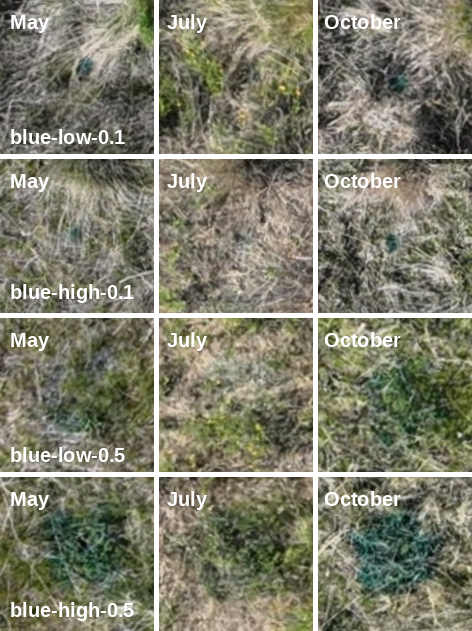

In [35]:
blue_col_items = [blue_low_0o1,  blue_high_0o1, blue_low_0o5, blue_high_0o5]
blue_col = join_v(blue_col_items)
blue_col

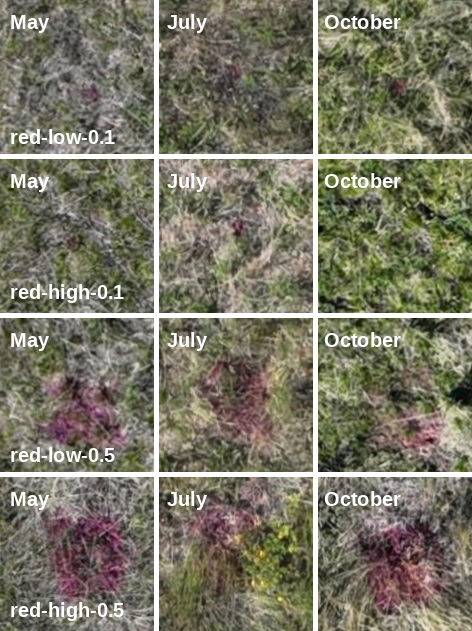

In [36]:
red_col_items = [red_low_0o1,  red_high_0o1, red_low_0o5, red_high_0o5]
red_col = join_v(red_col_items)
red_col


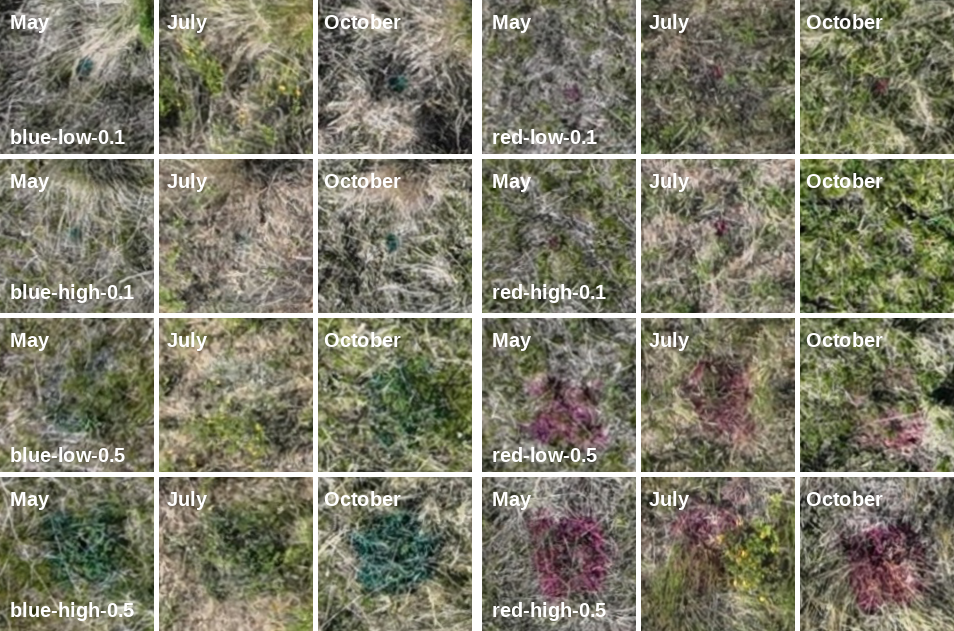

In [37]:
def stitch_cols_with_space(images, space=25):
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths) + (len(images) - 1) * space
    max_height = max(heights)

    new_img = Image.new('RGB', (total_width, max_height), 'white')  # 'white' background for the spaces

    x_offset = 0
    for im in images:
        new_img.paste(im, (x_offset, 0))
        x_offset += im.size[0] + space  # Move to the right for the next image plus the white space

    return new_img

# Assuming blue_col and red_col are Image objects
result_image = stitch_cols_with_space([blue_col, red_col], space=10)
result_image